In [1]:
from models.DecisionTree import DecisionTree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from IPython.display import Image
from IPython.core.display import HTML

## Introducción

Para evaluar nuestros árboles de decisión hemos decidido usar el método de cross-validation kfold. Hay varios puntos importantes que comentar antes de empezar con la evaluación de los modelos:  
- Hemos elegido <b>k=5 para kfold</b>, eso es, disponemos de 5 particiones distintas de nuestro dataset. Por lo tanto, hemos entrenado 5 modelos iguales pero usando distintos datos de entrenamiento (todas las particiones menos una) para cada caso. De la misma manera, <b>cada uno de los modelos deberá ser evaluado con la partición del dataset que no fue usada para su entrenamiento</b>.  


- Como veremos más adelante, <b>nuestro dataset dispone de pocos registros "ad" (con class=1) y muchos registros "noad" (con class=0)</b> por lo tanto lo que nos será interesante estudiar serán las métricas de <b>precision y recall (f1-score, que nos combina ambas métricas también)</b> de nuestros modelo a la hora de predecir registros "ad". Eso es así porque al haber un desbalanceo de los datos tan notable la métrica de <b>accuracy no no es relevante en este caso</b> (y siempre arroja buenos valores).  


- Los modelos deárbol de decisión que hemos generado tienen una <b>profundiadad máxima de 15</b>, es decir, hay un máximo de 15 nodos antes de llegar a una hoja. Eso es así ya que al tener nuetsro dataset un gran número de columnas (atributos) alrededor de las 1050, el timepo de cómputo para generar los árboles es demasiado elevado para nuestros equipos. Por lo tanto hemos decidido establecer un máximo de profundidad de 15, que <b>arroja buenos resultados sin llegar al overfitting y que además nos permite entrenar todos los modelos que presentaremos en un tiempo asumible</b>.

## Dataset

In [2]:
allData = pd.read_csv('../data/finalAdvertismentsDataset.csv')
allData.head(15)

,height,width,aratio,local,url.images.buttons,url.likesbooks.com,url.www.slake.com,url.hydrogeologist,url.oso,url.media,...,caption.home,caption.my,caption.your,caption.in,caption.bytes,caption.here,caption.click,caption.for,caption.you,class
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Nuestro dataset dispone de 1059 columnas, siendo <b>la última ('class') la columna a predecir</b>. Dispone de algunas filas que contienen valores 'unknown', hemos optado por <b>eliminar esas filas</b>. También cabe destacar que todos los atributos son binearios a excepción de las 3 primeras columnas 'height', 'width' y 'aratio' que hemos optado por <b>dividir en cuartiles</b> para entrenar y evaluar nuestros árboles.

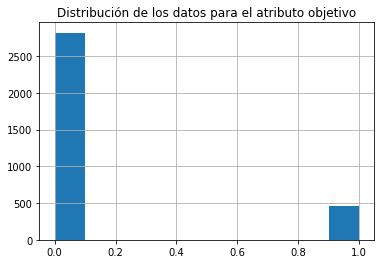

In [3]:
allData['class'].hist();
plt.title("Distribución de los datos para el atributo objetivo")
plt.show();

Tal como habíamos indicado antes, se puede observar un gran desbalanceo de los datos en el atributo a predecir.

## Evaluación de los modelos

Preparamos un diccionario para almacenar los resultados:

In [4]:
modelsResults = {}
for model in ['ID3', 'C4.5', 'Gini']:
    modelsResults[model] = {}
    for label in ['0.0','1.0']:
        modelsResults[model][label] = {}
        for metric in ['precision', 'recall', 'f1-score']:
            modelsResults[model][label][metric] = []

Cargamos las particiones de k-fold:

In [5]:
kFoldPartitions = []
for i in range(1,6):
    kFoldPartitions.append(pd.read_csv(f'../data/kfold/partition{i}of5.csv'))

### 1.- ID3

Cargamos los modelos entreados de ID3:

In [6]:
decisionTrees = []
for i in range(1,6):
    decisionTrees.append(DecisionTree().fromJSON(f'../outputs/modelsOutputs/ID3_maxDepth15__Partition{i}of5_isOutOfTraining.json'))

Con los modelos cargados, enseñamos la visualización de uno de ellos para hacernos una idea de como son:

In [7]:
decisionTrees[0].visualize('../outputs/graphOutputs/EjemploArbolID3')

In [8]:
Image(url="../outputs/graphOutputs/EjemploArbolID3.gv.png")

Evaluemos el modelo, para ello, como hemos explicado haremos que cada uno de los árboles entrenados haga predicciones sobre la partición del k-fold que no se usó para su entrenamiento. Seguidamente usaremos la media de las métricas obtenidas por los 5 modelos para determinar el rendimiento final.

In [9]:
for i in range(5):
    datasetToPredict = kFoldPartitions[i]
    model = decisionTrees[i]
    x = datasetToPredict.iloc[:,:-1]
    y = datasetToPredict.iloc[:,-1]
    prediction = model.predict(x)
    clasifReport = classification_report(y, prediction, output_dict=True)
    for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            modelsResults['ID3'][label][metric].append(clasifReport[label][metric])
for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            modelsResults['ID3'][label][metric] = np.mean(modelsResults['ID3'][label][metric])

In [10]:
for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            print(f"{metric} para clase {label} usando ID3: {modelsResults['ID3'][label][metric]}")

precision para clase 0.0 usando ID3: 0.9741034684615869
precision para clase 1.0 usando ID3: 0.9172433797433797
recall para clase 0.0 usando ID3: 0.9848619472254787
recall para clase 1.0 usando ID3: 0.8665379403794038
f1-score para clase 0.0 usando ID3: 0.9794107773238518
f1-score para clase 1.0 usando ID3: 0.8900429605909059


### 2.- C4.5

Procedemos de la misma manera para C4.5:

In [11]:
decisionTrees = []
for i in range(1,6):
    decisionTrees.append(DecisionTree().fromJSON(f'../outputs/modelsOutputs/C4.5_maxDepth15__Partition{i}of5_isOutOfTraining.json'))

In [12]:
decisionTrees[0].visualize('../outputs/graphOutputs/EjemploArbolC4.5')

In [13]:
Image(url="../outputs/graphOutputs/EjemploArbolc4.5.gv.png")

In [14]:
for i in range(5):
    datasetToPredict = kFoldPartitions[i]
    model = decisionTrees[i]
    x = datasetToPredict.iloc[:,:-1]
    y = datasetToPredict.iloc[:,-1]
    prediction = model.predict(x)
    clasifReport = classification_report(y, prediction, output_dict=True)
    for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            modelsResults['C4.5'][label][metric].append(clasifReport[label][metric])
for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            modelsResults['C4.5'][label][metric] = np.mean(modelsResults['C4.5'][label][metric])

In [15]:
for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            print(f"{metric} para clase {label} usando C4.5: {modelsResults['C4.5'][label][metric]}")

precision para clase 0.0 usando C4.5: 0.9600362283020616
precision para clase 1.0 usando C4.5: 0.9411621545949904
recall para clase 0.0 usando C4.5: 0.9904117510250068
recall para clase 1.0 usando C4.5: 0.7872154471544716
f1-score para clase 0.0 usando C4.5: 0.9749284036378615
f1-score para clase 1.0 usando C4.5: 0.8553813810639559


### 3.- Gini

Procedemos de la misma manera para Gini:

In [16]:
decisionTrees = []
for i in range(1,6):
    decisionTrees.append(DecisionTree().fromJSON(f'../outputs/modelsOutputs/Gini_maxDepth15__Partition{i}of5_isOutOfTraining.json'))

In [17]:
decisionTrees[0].visualize('../outputs/graphOutputs/EjemploArbolGini')

In [18]:
Image(url="../outputs/graphOutputs/EjemploArbolGini.gv.png")

In [19]:
for i in range(5):
    datasetToPredict = kFoldPartitions[i]
    model = decisionTrees[i]
    x = datasetToPredict.iloc[:,:-1]
    y = datasetToPredict.iloc[:,-1]
    prediction = model.predict(x)
    clasifReport = classification_report(y, prediction, output_dict=True)
    for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            modelsResults['Gini'][label][metric].append(clasifReport[label][metric])
for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            modelsResults['Gini'][label][metric] = np.mean(modelsResults['Gini'][label][metric])

In [20]:
for metric in ['precision', 'recall', 'f1-score']:
        for label in ['0.0', '1.0']:
            print(f"{metric} para clase {label} usando Gini: {modelsResults['Gini'][label][metric]}")

precision para clase 0.0 usando Gini: 0.9707616774763371
precision para clase 1.0 usando Gini: 0.9235547047992526
recall para clase 0.0 usando Gini: 0.9864063671541619
recall para clase 1.0 usando Gini: 0.84619918699187
f1-score para clase 0.0 usando Gini: 0.978485327614868
f1-score para clase 1.0 usando Gini: 0.8822384281917055


## Comparación de modelos

- Comparación general:

In [21]:
models = ['ID3', 'C4.5', 'Gini']
classes = ['0.0', '1.0']
metrics = ['precision', 'recall', 'f1-score']
data = []
for model in models:
    for metric in metrics:
        for label in classes:
            data.append(modelsResults[model][label][metric])
data = np.array(data)
data = np.around(data, 3)
comparisonDataframe = pd.DataFrame(data.reshape(3,6),
            index=models,
            columns=['precisionClass0', 'precisionClass1', 'recallClass0', 'recallClass1', 'f1-scoreClass0', 'f1-scoreClass1'])

In [22]:
comparisonDataframe

,precisionClass0,precisionClass1,recallClass0,recallClass1,f1-scoreClass0,f1-scoreClass1
ID3,0.974,0.917,0.985,0.867,0.979,0.890
C4.5,0.960,0.941,0.990,0.787,0.975,0.855
Gini,0.971,0.924,0.986,0.846,0.978,0.882


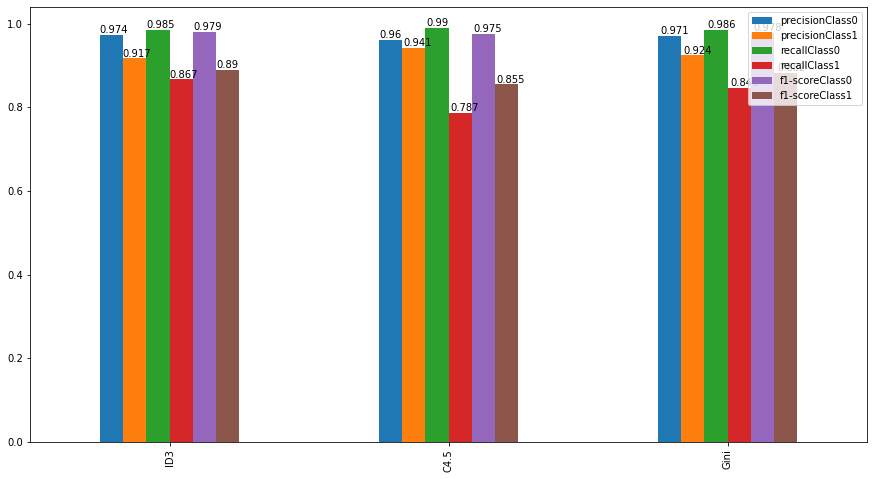

In [23]:
ax = comparisonDataframe.plot(kind='bar', figsize=(15,8));
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Compraración para la clase 'ad':

In [24]:
models = ['ID3', 'C4.5', 'Gini']
classes = ['1.0']
metrics = ['precision', 'recall', 'f1-score']
data = []
for model in models:
    for metric in metrics:
        for label in classes:
            data.append(modelsResults[model][label][metric])
data = np.array(data)
data = np.around(data, 2)
comparisonDataframe = pd.DataFrame(data.reshape(3,3),
            index=models,
            columns=['precisionClass1', 'recallClass1', 'f1-scoreClass1'])

In [25]:
comparisonDataframe

,precisionClass1,recallClass1,f1-scoreClass1
ID3,0.92,0.87,0.89
C4.5,0.94,0.79,0.86
Gini,0.92,0.85,0.88


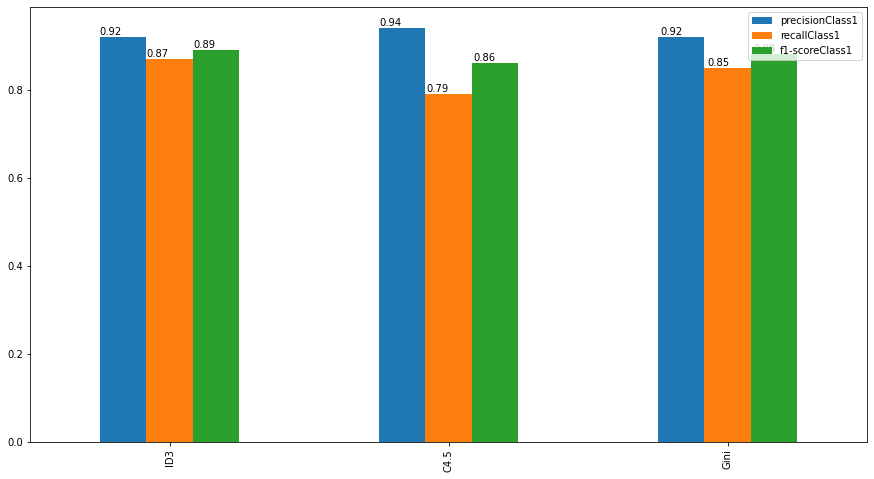

In [26]:
ax = comparisonDataframe.plot(kind='bar', figsize=(15,8));
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Conclusión

ID3 nos arroja unos valores de precision iguales a los de Gini y únicamente un poco por debajo de C4.5. Además, nos otorga los mejores valores para recall. Siendo además muy equilibrado obtiene como es de esperar, el mejor valor para la métrica f1-score tanto en la clase 0 como en la clase 1 (a la que le damos la mayor importáncia). Es por esto que si tuviérmaos que usar alguno de nuestros modelos entrenados para clasificar muestras de este dataset, <b>nos inclinaríamos por usar ID3 como criterio de partición en nuestros árboles</b>.